In [1]:
from fomoh.hyperdual import HyperTensor as htorch
from fomoh.util import jac_vector_build, hess_vector_build
import matplotlib.pyplot as plt
import torch
import hamiltorch

### Example of Fomoh hyper-dual numbers:
* Here we start with a simple example using a single input, single output function of $\sin x$. 
* We then plot three components of the hyper-dual number (since we set both tangents to be the same there is no point plotting both).
* The primal is given by the attribute `real`, e.g. `y_h.real`. The two first-order components are given by `eps1` and `eps2`, while the second-order component is given by `eps1eps2`.

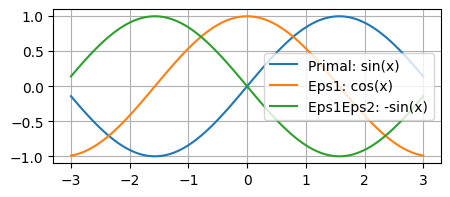

In [2]:
# Uni-dimensional gives exact outputs:
x = torch.linspace(-3,3,100)
tangent = torch.ones_like(x)

x_h = htorch(x, tangent, tangent)
y_h = x_h.sin() # Forward Pass of hyper-dual tensor

plt.figure(figsize=(5,2))
plt.plot(x_h.real, y_h.real, label = "Primal: sin(x)")
plt.plot(x_h.real, y_h.eps1, label = "Eps1: cos(x)")
plt.plot(x_h.real, y_h.eps1eps2, label = "Eps1Eps2: -sin(x)")
plt.grid()
plt.legend()
plt.savefig("fomoh_example1d.png")
plt.show()

### Extending Fomoh to multidimensional inputs with the Rosenbrock function

In [3]:
## Define Ground Truth for Rosenbrock functions

def rosenbrock(x):
    return (1.-x[:,0]) ** 2. + 100. * (x[:,1] - x[:,0]**2)**2

def rosenbrockJacobian(x):
    return torch.tensor([[-2.*(1-x[:,0])-400.*x[:,0]*(x[:,1] - x[:,0]**2)], [200.*(x[:,1] - x[:,0]**2)]])

def rosenbrockHessian(x):
    return torch.tensor([[2.+1200.*x[:,0]*x[:,0]-400.*x[:,1], -400.*x[:,0]],[-400.*x[:,0], 200.*1.]])


* Let's check that we can loop over a one-hot basis to recover the Jacobian and the Hessian:

$$f(\boldsymbol{\theta}) + \nabla f(\boldsymbol{\theta})_i \epsilon_1 + \nabla f(\boldsymbol{\theta})_j \epsilon_2 + \nabla^2 f(\boldsymbol{\theta})_{ij} \epsilon_1\epsilon_2= f(\boldsymbol{\theta} + \mathbf{e}_i\epsilon_1 + \mathbf{e}_j\epsilon_2 + \mathbf{0}\epsilon_1\epsilon_2).$$

In [4]:
x = torch.randn(2).view(1,-1)

H = torch.zeros(2,2)
J1 = torch.zeros(1,2)
J2 = torch.zeros(1,2)

for basis in hess_vector_build(2):
    xeps1 = basis[0].view(1,-1)
    xeps2 = basis[1].view(1,-1)
    x_htorch = htorch(x, xeps1, xeps2)
    z = rosenbrock(x_htorch)
    H[(basis[0].view(-1,1) @ basis[1].view(1,-1)).bool()] += z.eps1eps2.sum()
    J1[xeps1.bool()] += z.eps1.sum()
    J2[xeps2.bool()] += z.eps2.sum()

In [5]:
print("Jacobians match: ", torch.allclose(J1/2, rosenbrockJacobian(x).t())) # We counted the Jacobian twice in this loop
print("Hessians match: ", torch.allclose(H, rosenbrockHessian(x)))

Jacobians match:  True
Hessians match:  True


### Comparison of Forward-Mode-Only Optimization over 2D Rosenbrock
* We define our optimization loop along with the three forward-mode optimization update steps: 
    * Forward Gradient Descent (Baydin et al. 2022)
    * FoMoH: Forward-Mode Weight Perturbation with Hessian Information (Line Search)
    * FoMoH-KD: Forward-Mode Weight Perturbation with Hessian Information Hyperplane Search

In [6]:
from fomoh.opt import plane_step_Nd
hamiltorch.set_random_seed(0)

x_init = torch.randn(2).view(1,-1)
fun = rosenbrock
N = 1000

def optimizer(x_init, fun, update, iterations):
    x = x_init.clone()
    thetas = [x]
    loss = [fun(x).item()]
    for n in range(iterations):
        u = update(x)
        x = x + u # minimize
        loss.append(fun(x).item())
        thetas.append(x.clone())
    return thetas, loss

# FGD
def fgd(x, lr = 0.0001):
    v = torch.randn(x.shape)
    z = fun(htorch(x,v,v))
    return - lr * z.eps1 * v

# FoMoH
def fomoh(x):
    v = torch.randn(x.shape)
    z = fun(htorch(x,v,v))
    return - z.eps1 * v / abs(z.eps1eps2)

# FoMoH-2D
fomoh_2d = lambda x: plane_step_Nd(fun, x, 2)


## Run optimizers:
fgd_thetas, fgd_loss = optimizer(x_init, fun, fgd, N)
fomoh_thetas, fomoh_loss = optimizer(x_init, fun, fomoh, N)
fomoh_2d_thetas, fomoh_2d_loss = optimizer(x_init, fun, fomoh_2d, N)


Attempt 1: Error detected - linalg.inv: The diagonal element 2 is zero, the inversion could not be completed because the input matrix is singular.
Adding jitter to the diagonal: 0.001
Inversion successful after adding jitter: 0.001
Attempt 1: Error detected - linalg.inv: The diagonal element 2 is zero, the inversion could not be completed because the input matrix is singular.
Adding jitter to the diagonal: 0.001
Inversion successful after adding jitter: 0.001


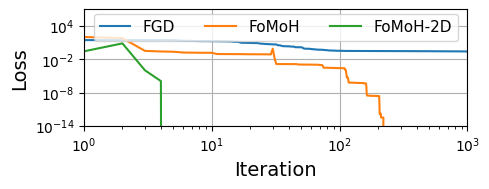

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
plt.plot(fgd_loss, label = "FGD")
plt.plot(fomoh_loss, label = "FoMoH")
plt.plot(fomoh_2d_loss, label = "FoMoH-2D")
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlim(1,1000)
plt.ylim(10e-15,10000000)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.legend(fontsize = 11, ncol= 3, loc='upper center', bbox_to_anchor=(0.5, 1.03))
plt.tight_layout()
plt.savefig("rosen_example.png")
plt.show()

### FoMoH-KD Performance when Increasing Hyperplane Dimension "K"

In [8]:
# N dimensional Rosenbrock function
def rosenbrock_ND(x):
    term1 = (1 - x[:, :-1])**2
    term2 = 100 * (x[:, 1:] - x[:, :-1]**2)**2
    return (term1 + term2).sum(-1)

* Iterate through the FoMoH-KD optimization routines, starting with K=1, for a 5D Rosenbrock function.

In [9]:
hamiltorch.set_random_seed(0)
D = 5 # Dimension of Rosenbrock function
N = 1000 # Optimization Iterations
fun = rosenbrock_ND
x_init = torch.randn(D).view(1,-1)

thetas_list = []
loss_list = []
for d in range(1,D+1):
    # Define K=d update step
    fomoh_Kd = lambda x: plane_step_Nd(fun, x, d)
    ## Run optimizer:
    thetas, loss = optimizer(x_init, fun, fomoh_Kd, N)
    thetas_list.append(thetas)
    loss_list.append(loss)

Attempt 1: Error detected - linalg.inv: The diagonal element 5 is zero, the inversion could not be completed because the input matrix is singular.
Adding jitter to the diagonal: 0.001
Inversion successful after adding jitter: 0.001


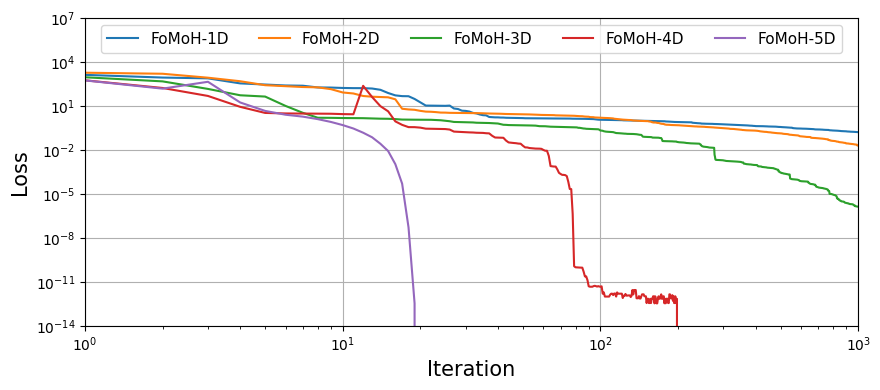

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
for d in range(1,D+1):
    plt.plot(loss_list[d-1], label = f"FoMoH-{d}D")
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlim(1,1000)
plt.ylim(10e-15,10000000)
plt.xlabel("Iteration", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend(fontsize = 11, ncol= 5, loc='upper center', bbox_to_anchor=(0.5, 1.0))#1.17))
plt.tight_layout()
# plt.savefig("rosen_K_example.png")
plt.show()